# Skew T Log P 

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import datetime

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1),
})


In [2]:
# get data
df = pd.read_csv(os.path.join("data", "RAWDATA1.csv"), skiprows=range(1,49))

graph_folder = "Fall2025Graphs"

In [3]:
print(df.columns)

Index(['Millis', 'INA260 Current (mA)', 'INA260 Voltage (mV)',
       'INA260 Power (mW)', 'PicoTemp Temp (C)', 'MTK3339 Year',
       'MTK3339 Month', 'MTK3339 Day', 'MTK3339 Hour', 'MTK3339 Minute',
       'MTK3339 Second', 'MTK3339 Latitude', 'MTK3339 Longitude',
       'MTK3339 Speed', 'MTK3339 Heading', 'MTK3339 Altitude',
       'MTK3339 Satellites', 'ICM20948 AccX (g)', 'ICM20948 AccY (g)',
       'ICM20948 AccZ (g)', 'ICM20948 GyroX (deg/s)', 'ICM20948 GyroY (deg/s)',
       'ICM20948 GyroZ (deg/s)', 'ICM20948 MagX (uT)', 'ICM20948 MagY (uT)',
       'ICM20948 MagZ (uT)', 'ICM20948 Temp (C)', 'PCF8523 Year',
       'PCF8523 Month', 'PCF8523 Day', 'PCF8523 Hour', 'PCF8523 Minute',
       'PCF8523 Second', 'TMP117 Temp (C)', 'UV_Sensor_O UVA2 (nm)',
       'UV_Sensor_O UVB2 (nm)', 'UV_Sensor_O UVC2 (nm)', 'ENS160_O AQI',
       'ENS160_O TVOC (ppb)', 'ENS160_O eCO2 (ppm)', 'BMP390_O Temp (C)',
       'BMP390_O Pressure (Pa)', 'BMP390_O Altitude (m)',
       'TMP117_O Temp_O (C)',

float64
   Millis  INA260 Current (mA)  INA260 Voltage (mV)  INA260 Power (mW)  \
0   36402               948.75              3362.50             3190.0   
1   36934                  NaN                  NaN                NaN   
2   37465               930.00              3378.75             3150.0   
3   37998                  NaN                  NaN                NaN   
4   39448               930.00              3367.50             3120.0   

   PicoTemp Temp (C)  MTK3339 Year  MTK3339 Month  MTK3339 Day  MTK3339 Hour  \
0          19.648264           NaN            NaN          NaN           NaN   
1                NaN           NaN            NaN          NaN           NaN   
2          17.307579           NaN            NaN          NaN           NaN   
3                NaN        2025.0           12.0          6.0          17.0   
4          14.498748           NaN            NaN          NaN           NaN   

   MTK3339 Minute  ...  BMP390_O Temp (C)  BMP390_O Pressure (Pa) 

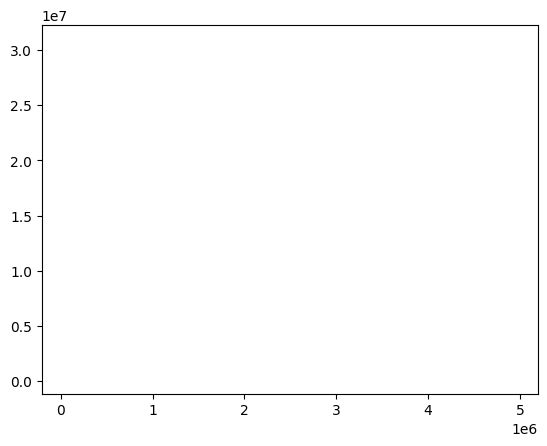

In [4]:
R = 10_000 # 10kOhms 
A = 1.130801397e-03
B = 2.338433402e-04
C = 0.8887342465e-07
# # R2 = R1 * (1023.0 / (float)Vo – 1.0);

def adc_to_temp(adc): 
    v = 3.3 * (adc / 1023) 
    Rt = R * (v / (3.3 - v)) # lower 
    # upper Rt = R * (Vin / Vout = 1) 
    Rt_log = math.log(Rt) 
    T = 1 / (A + B * Rt_log + C * Rt_log**3)
    return T - 273.15

df["Temp (C)"] = df['Analog_Temp_0 ADC_val'].apply(adc_to_temp)

def pressure_from_altitude(altitude_m, temp_c, p0=101325):
    """
    Estimate pressure (Pa) at a given altitude (m) and temperature (°C)
    using the isothermal barometric equation.
    """
    g = 9.80665          # m/s^2
    R = 287.05           # J/(kg*K)
    T = temp_c + 273.15  # convert °C to K

    return p0 * math.exp(-(g * altitude_m) / (R * T))


print(df["MTK3339 Altitude"].dtype)
sim_pressures = []
for i in range(len(df)):
    if np.isnan(df["MTK3339 Altitude"][i]) or np.isnan(df['Temp (C)'][i]):
        sim_pressures.append(np.nan)
    else:
        sim_pressures.append(pressure_from_altitude(df["MTK3339 Altitude"][i] / 1000, df['Temp (C)'][i]))

df["Sim Pres (Pa)"] = sim_pressures

print(df.head())

print(df["Millis"].dtype, df["Sim Pres (Pa)"].dtype)

plt.plot(df["Millis"], df["MTK3339 Altitude"])

plt.show()

In [7]:
# data
wind_speed = []
course = []
pres = []
temp = []
rel_hum = [] 

SPEED_COL = "MTK3339 Speed"
COURSE_COL = "MTK3339 Heading"
PRES_COL = "Sim Pres (Pa)"
TEMP_COL = "SHTC3_O Temp (C)"
REL_HUM_COL = "SHTC_O Rel Hum (%)"

last_pres = 10000
for index, row in df.iterrows():
    if last_pres < 100: break
    if pd.isnull(df.loc[index, "MTK3339 Speed"]) == False and pd.isnull(df.loc[index, PRES_COL]) == False and row[PRES_COL] / 100 < last_pres:
        wind_speed.append(row["MTK3339 Speed"] * 0.001 * 0.2777778)
        course.append(row["MTK3339 Heading"] * 10**-5)
        pres.append(row[PRES_COL] / 100)
        last_pres = row[PRES_COL] / 100

        temp.append(row["SHTC3_O Temp (C)"])
        rel_hum.append(row["SHTC3_O Rel Hum (%)"] / 100)
#         data_index += 1
        
#     print(target_time, index_time, data_index, wind_speed[-1], course[-1], pres[-1], temp[-1], rel_hum[-1])
    
    #if(flash_df["BMEPress(hPa)"][data_index] < 100): break

step = 5
wind_speed = [wind_speed[i] for i in range(0, len(wind_speed), step)]
course = [360-course[i] for i in range(0, len(course), step)]
pres = [pres[i] for i in range(0, len(pres), step)]
temp = [temp[i] for i in range(0, len(temp), step)]
rel_hum = [rel_hum[i] for i in range(0, len(rel_hum), step)]


print(len(wind_speed), len(course), len(pres), len(temp), len(rel_hum), sep="\t")
print("Speed", "Course", "Pres", "Temp", "Rel Hum", sep="\t")
for i in range(10):   #(len(wind_speed)):
    print(round(wind_speed[i], 4), round(course[i],2), round(pres[i],2), round(temp[i],2), round(rel_hum[i], 4), sep="\t")

108	108	108	108	108
Speed	Course	Pres	Temp	Rel Hum
0.0269	360.0	972.14	12.56	0.6104
0.4586	33.94	966.92	12.95	0.5222
1.4103	42.19	953.95	13.12	0.474
1.1481	25.78	943.55	13.48	0.4128
0.415	273.24	932.84	13.94	0.3864
0.3042	173.78	921.38	14.07	0.3654
0.9622	247.19	911.01	14.14	0.3462
0.7156	317.47	900.98	14.2	0.3235
0.7442	230.9	891.05	14.65	0.2902
0.1739	210.28	882.16	15.04	0.2488


C:\Users\tyler\AppData\Local\Temp\ipykernel_28492\1813214355.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pres = np.array(pres) * units.hPa
C:\Users\tyler\AppData\Local\Temp\ipykernel_28492\1813214355.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  temp = np.array(temp) * units.degC
C:\Users\tyler\AppData\Local\Temp\ipykernel_28492\1813214355.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ 

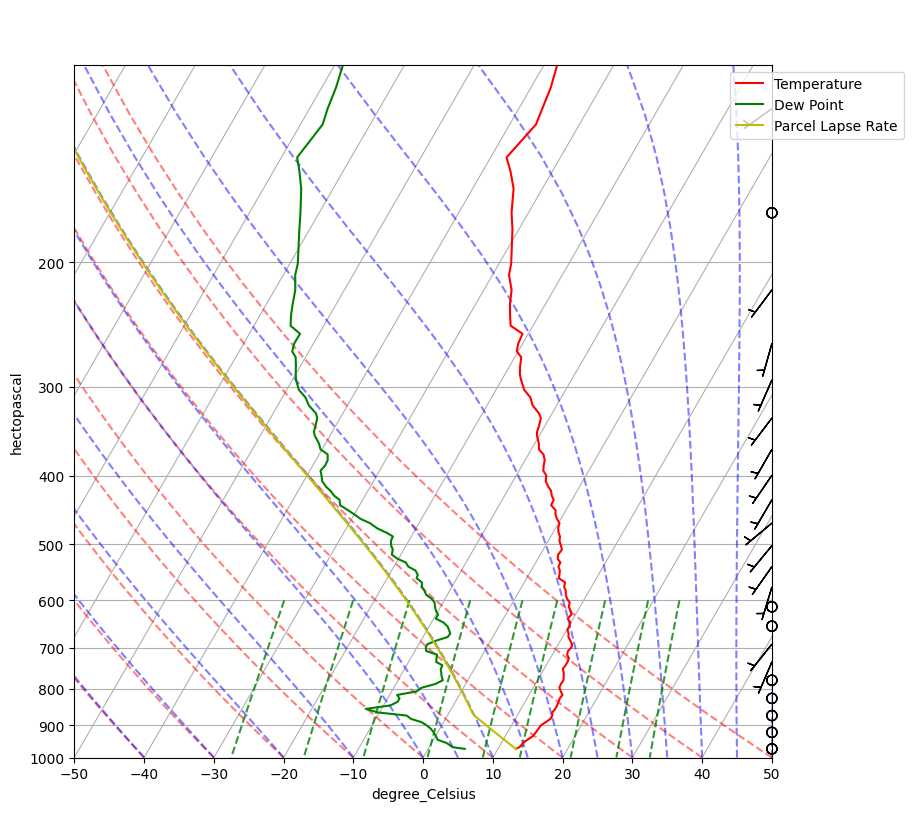

In [9]:
# skewT
fig = plt.figure(figsize = (9,9))
skew = SkewT(fig=fig, aspect='auto')

pres = np.array(pres) * units.hPa
temp = np.array(temp) * units.degC
rel_hum = np.array(rel_hum) * units.dimensionless
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature=temp, relative_humidity=rel_hum)

prof = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')

# # fix with aprs data 
# u = wind_speed * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

wind_speed = np.array(wind_speed) * units("m/s")
course = np.array(course) * units.deg

u, v = mpcalc.wind_components(wind_speed, course)
# u = np.linspace(-10, 10, len(pres)) * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

skew.plot(pres, temp, 'r')
skew.plot(pres, dewpoint, 'g')
skew.plot(pres, prof, 'y')
skew.plot_barbs(pres[::5], u[::5], v[::5])

skew.ax.set_xlim(-50, 50)
skew.ax.set_ylim(1000, min(pres))

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.legend(("Temperature","Dew Point", "Parcel Lapse Rate"), shadow=False, fancybox=True, bbox_to_anchor = [0.93, 1]) #Legend providing same color for both


plt.savefig(os.path.join(graph_folder, f"skewTLogP.svg"))
plt.savefig(os.path.join(graph_folder, f"skewTLogP.png"))

plt.show()